In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

General outlook: 

* Current season and historical scoring -> swarm plot of points at each game

    * Distribution of points from locations compared with those other top scorers (2pt/3pt/FT)
    
    * Compare how many field goals which he made were assisted/unassisted with this year/historic players
    
    * Compare free throw shooting with other players.
    
    * Step backs comparison (like with Doncic)
    
    * Step backs shot chart
    
    * Shotchart for this year
    
        
* Evolution of Harden

    * Shotchart through time would be nice to see
    
    * How his usage rose through time
    
    * Change in style from OKC to HOU
    
    
* Comparsion with Phoenix' system with D'Antoni

    * Compare Harden with Steve Nash
    
    * Shot charts comparison

## Setup

In [2]:
from nba_api.stats.static.players import find_players_by_full_name

In [3]:
harden_data = find_players_by_full_name("James Harden")

In [4]:
harden_id = harden_data[0]['id']

## Analyzing shooting splits

In [14]:
import time

In [5]:
from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits

In [11]:
int_seasons = list(range(2009, 2019))

In [32]:
harden_shot_types_df = None
harden_overall_df = None
seasons = list()
for i in range(len(int_seasons)):
    season_str = str(int_seasons[i]) + "-" + str(int_seasons[i]+1)[-2:]
    data_frames = PlayerDashboardByShootingSplits(
            player_id=harden_id,
            season=season_str).get_data_frames()
    shot_type_detail = data_frames[-2]
    shot_type_detail.loc[:, 'SEASON'] = season_str
    overall = data_frames[0]
    overall.loc[:, 'SEASON'] = season_str
    time.sleep(1)
    if harden_shot_types_df is None:
        harden_shot_types_df = shot_type_detail
        harden_overall_df = overall
    else:
        harden_shot_types_df = harden_shot_types_df.append(shot_type_detail, ignore_index=True)
        harden_overall_df = harden_overall_df.append(overall, ignore_index=True)

In [44]:
step_backs = harden_shot_types_df.loc[harden_shot_types_df.GROUP_VALUE == 'Step Back Jump shot']

In [40]:
plt.style.use('seaborn')

In [48]:
step_backs.FGA.tolist()

[2, 15, 17, 70, 147, 191, 199, 155, 267, 375]

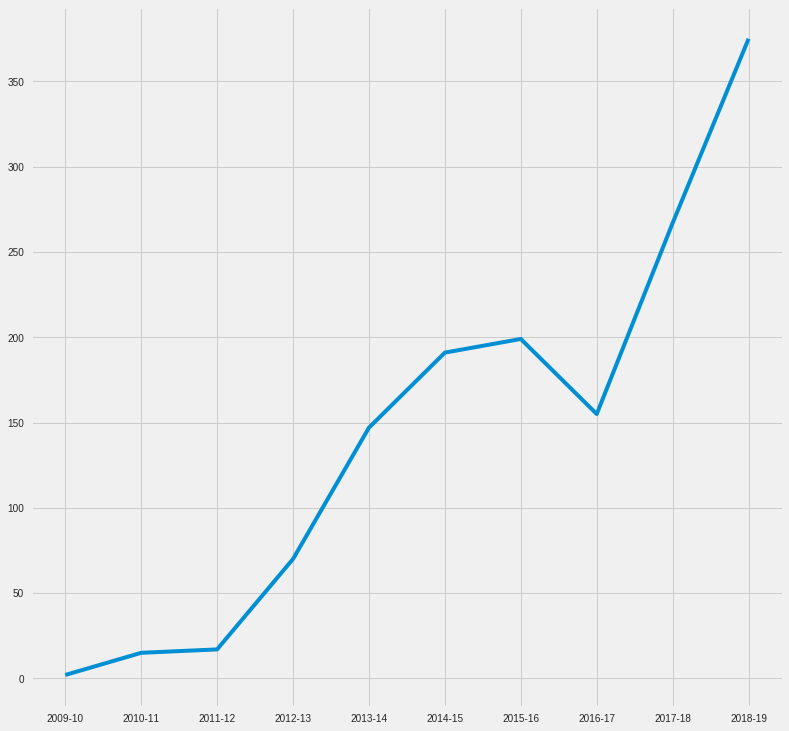

In [64]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot('SEASON', 'FGA', data=step_backs)


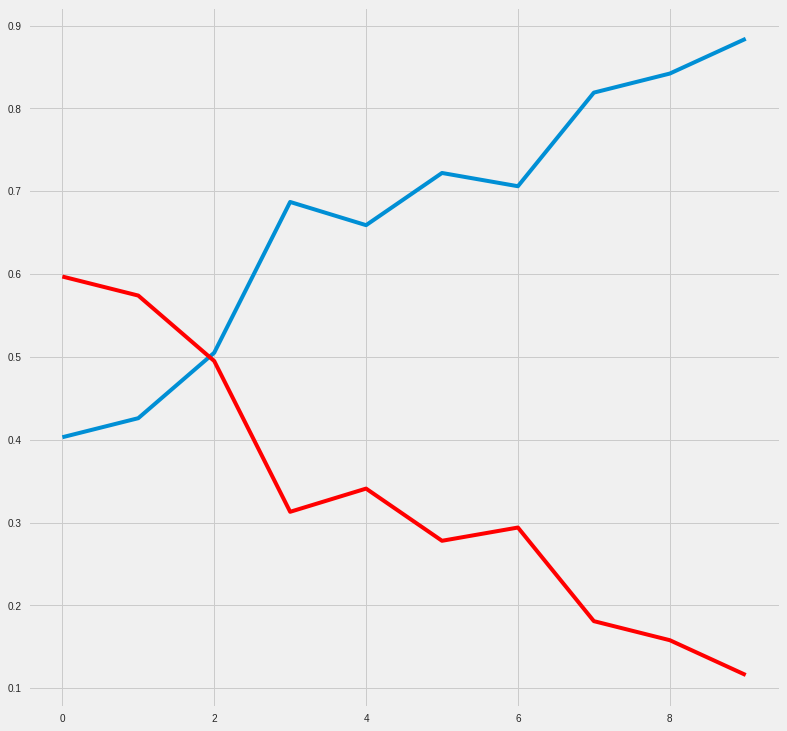

In [60]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(harden_overall_df.PCT_UAST_FGM)
ax.plot(harden_overall_df.PCT_AST_FGM, color='r')